In [2]:
import os

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

LANGCHAIN_TRACING_V2 = os.getenv("LANGCHAIN_TRACING_V2")
os.environ["LANGCHAIN_TRACING_V2"] = LANGCHAIN_TRACING_V2

LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY

LANGCHAIN_PROJECT = os.getenv("LANGCHAIN_PROJECT")
os.environ["LANGCHAIN_PROJECT"] = LANGCHAIN_PROJECT

In [6]:
from langgraph.graph import Graph
from IPython.display import Image , display

In [7]:
def function1(input1):
    return input1 + " first function"
def function2(input2):
    return input2 + " second function"

In [8]:
workflow= Graph()

# adding nodes
workflow.add_node("function1" , function1)
workflow.add_node("function2" , function2)

# adding edges
workflow.add_edge("function1" , "function2")

# entry point 
workflow.set_entry_point("function1")

# finish point
workflow.set_finish_point("function2")


app = workflow.compile()

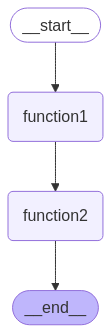

In [9]:
display( 
   Image(
        app.get_graph().draw_mermaid_png()
    )  
)

In [10]:
result = app.invoke("Yo i am here")
print(result)

Yo i am here first function second function


In [11]:
#Debugging 

input = "Yo i am here"
for output in app.stream(input):
    for key,value in output.items():
        print(f'here is output from {key}')
        print("---")
        print(value)
        print("\n")


here is output from function1
---
Yo i am here first function


here is output from function2
---
Yo i am here first function second function




let's integrate llm in the workflow

In [12]:
from langchain_google_genai import ChatGoogleGenerativeAI

In [13]:
def story_teller(input):
    llm = ChatGoogleGenerativeAI(model = "gemini-1.5-pro" , temperature = 0 , max_tokens=1000)
    response = llm.invoke(f"Write me a brief story on {input}").content
    return response

def add_humour(input):
    llm = ChatGoogleGenerativeAI(model = "gemini-1.5-pro" , temperature = 0 , max_tokens=1000)
    response = llm.invoke(f"here is the story : {input} , add some humour in the story").content
    return response

In [14]:
workflow = Graph()

# adding nodes
workflow.add_node(" story_teller" ,  story_teller)
workflow.add_node("add_humour" , add_humour)

# adding edges
workflow.add_edge(" story_teller" , "add_humour")

# entry point 
workflow.set_entry_point(" story_teller")

# finish point
workflow.set_finish_point("add_humour")

app = workflow.compile()

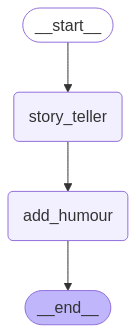

In [15]:
display( 
   Image(
        app.get_graph().draw_mermaid_png()
    )  
)

In [16]:

input = "Flying French Fries"
for output in app.stream(input):
    for key,value in output.items():
        print(f'here is output from {key}')
        print("---")
        print(value)
        print("\n")


here is output from  story_teller
---
The Flying French Fries weren't your average potatoes. Oh no. These spuds had spunk.  They’d been plucked from the fertile fields of Idaho, destined for greasy glory, but fate, in the form of a rogue lightning strike on Farmer McGregor's experimental fertilizer silo, had other plans.

The lightning imbued the fries with a strange, buoyant energy.  As they sizzled in the deep fryer of the local diner, they began to levitate, golden and crispy, defying gravity.  Panic ensued.  Customers screamed, the short-order cook fainted, and the fries, sensing freedom, ascended through the roof vent.

They became a local legend, the Flying French Fries of Idaho.  Some said they formed a swirling vortex of salty goodness high above the state. Others claimed they’d seen them dive-bombing unsuspecting picnickers, dispensing ketchup packets from tiny, fry-fashioned parachutes.  Truckers reported near-misses with airborne potato projectiles, leaving greasy streaks ac

let's integrate rag in the workflow

In [22]:
from langchain.document_loaders import TextLoader , WebBaseLoader

text_loader = TextLoader('/Users/akashjain/Desktop/LangGraph/Util/Indian_economy.txt')
document = text_loader.load()

from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size = 200 , chunk_overlap = 50 )
text_chunks = text_splitter.split_documents(documents=document)


from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model = "models/embedding-001")

from langchain.vectorstores import FAISS

vector_store = FAISS.from_documents( text_chunks , embedding=embeddings)
retriever = vector_store.as_retriever(search_kwargs = {"k" : 3})

In [23]:
query = "Tell me about india's economical growth"
docs = retriever.get_relevant_documents(query)

for doc in docs:
    print(doc)

page_content='Inflation Rate: Managed at a stable 4.1%, with food prices stabilizing and fuel costs showing a slight decline.
India’s last eight years of GDP (hypothetical data):' metadata={'source': '/Users/akashjain/Desktop/LangGraph/Util/Indian_economy.txt'}
page_content='India’s strong export sectors—including textiles, IT services, and automotive manufacturing—had seen sluggish growth due to uncertain global demand, leading to a 0.2% contraction in the last quarter' metadata={'source': '/Users/akashjain/Desktop/LangGraph/Util/Indian_economy.txt'}
page_content='growth.” The government has announced targeted fiscal policies to support emerging sectors like renewable energy, electronics, and healthcare manufacturing.' metadata={'source': '/Users/akashjain/Desktop/LangGraph/Util/Indian_economy.txt'}
